## Selecting Useful features

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings("ignore")

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author
)

from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)

from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

%load_ext autoreload
%autoreload 2
np.random.seed(42)

data_path=Path("../data/writers.csv")
df=pd.read_csv(data_path)
df=format_raw_df(df.copy())

df=df.loc[df["is_question"]].copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df["full_text"]=df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")


In [4]:
df=add_char_count_features(df.copy())
df=get_word_stats(df.copy())
df=get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:15<00:00, 529.95it/s]


In [5]:
feature_arr=[
    "num_questions",
    "num_periods",
    "num_commas",
    "num_exclam",
    "num_quotes",
    "num_colon",
    "num_stops",
    "num_semicolon",
    "num_words",
    "num_chars",
    "num_diff_words",
    "avg_word_len",
    "polarity"
]

feature_arr.extend(POS_NAMES.keys())

## Model

In [6]:
train_df, test_df=get_split_by_author(df, test_size=0.2, random_state=40)

In [7]:
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.0,1022.727273,0.0,2073.863636,35200,...,3.125000,0.000000,1.136364,2.272727,0.000000,1.988636,0.568182,0.000000,3.693182,0.0
2,90.634441,30.211480,60.422961,0.0,60.422961,0.0,1087.613293,0.0,2024.169184,33100,...,4.229607,0.000000,0.000000,1.812689,0.000000,2.416918,0.302115,0.000000,1.510574,0.0
3,175.438596,87.719298,87.719298,0.0,0.000000,0.0,1491.228070,0.0,2719.298246,11400,...,2.631579,0.877193,0.000000,6.140351,0.000000,3.508772,1.754386,0.000000,5.263158,0.0
5,70.257611,46.838407,117.096019,0.0,0.000000,0.0,843.091335,0.0,2154.566745,42700,...,3.747073,0.000000,1.170960,0.936768,0.000000,2.810304,0.468384,0.234192,3.512881,0.0
7,135.135135,67.567568,67.567568,0.0,0.000000,0.0,945.945946,0.0,2027.027027,14800,...,2.027027,0.000000,0.000000,2.702703,1.351351,2.702703,0.675676,0.000000,1.351351,0.0


In [8]:
def get_feature_vector_and_label(df, feature_names):
    """
    Generate input and output vectors using the vectors feature and 
    the given feature names
    :param df: input DataFrame
    :param feature_names: names of feature columns (other than vectors)
    :return: feature array and label
    """
    features=df[feature_names].astype(str)
    labels=df["Score"] > df["Score"].median()
    return features, labels


X_train, y_train=get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test=get_feature_vector_and_label(test_df, feature_arr)

In [9]:
y_train.value_counts()

Score
False    3483
True     2959
Name: count, dtype: int64

In [10]:
X_test.shape

(1529, 30)

In [11]:
clf=RandomForestClassifier(n_estimators=100, class_weight="balanced", oob_score=True)
clf.fit(X_train, y_train)


y_predicted=clf.predict(X_test)
y_predicted_proba=clf.predict_proba(X_test)

In [12]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives + false positives)
    precision=precision_score(y_test, y_predicted, pos_label=True, average='binary')

    # true positives / (true positives + false negatives)
    recall=recall_score(y_test, y_predicted, pos_label=True, average='binary')

    # harmonic mean of preciion and recall
    f1=f1_score(y_test, y_predicted, pos_label=True, average='binary')

    # true positives + true negatives / total
    accuracy=accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1




In [13]:
# Training accuracy
y_train_pred=np.argmax(clf.oob_decision_function_, axis=1)

accuracy, precision, recall, f1=get_metrics(y_train, y_train_pred)
print(f"Taining accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}")

Taining accuracy: 0.575, precision: 0.547, recall: 0.430, f1_score: 0.482


In [15]:
accuracy, precision, recall, f1=get_metrics(y_test, y_predicted)
print(f"Validation accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}")

Validation accuracy: 0.579, precision: 0.590, recall: 0.455, f1_score: 0.514


In [17]:
model_path=Path("../models/model_3.pkl")
joblib.dump(clf, model_path)

['..\\models\\model_3.pkl']

## Validating that features are useful

In [20]:
all_feature_names=np.array(feature_arr)

In [21]:
k = 20
print(f"Top {k} importances:\n")
print('\n'.join([f"{tup[0]}: {tup[1]:.2g}" for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print(f"\nBottom {k} importances:\n")
print('\n'.join([f"{tup[0]}: {tup[1]:.2g}" for tup in get_feature_importance(clf, all_feature_names)[-k:]]))



Top 20 importances:

num_periods: 0.049
num_questions: 0.049
num_chars: 0.048
ADJ: 0.045
num_diff_words: 0.044
ADV: 0.044
DET: 0.043
AUX: 0.043
num_commas: 0.042
ADP: 0.042
SCONJ: 0.042
PUNCT: 0.042
PART: 0.042
num_stops: 0.041
PRON: 0.041
VERB: 0.04
NOUN: 0.04
polarity: 0.039
num_words: 0.038
avg_word_len: 0.037

Bottom 20 importances:

SCONJ: 0.042
PUNCT: 0.042
PART: 0.042
num_stops: 0.041
PRON: 0.041
VERB: 0.04
NOUN: 0.04
polarity: 0.039
num_words: 0.038
avg_word_len: 0.037
PROPN: 0.031
NUM: 0.025
num_colon: 0.022
num_quotes: 0.019
SYM: 0.013
INTJ: 0.013
X: 0.011
num_semicolon: 0.0069
num_exclam: 0.0065
CONJ: 0


## Comparing to data

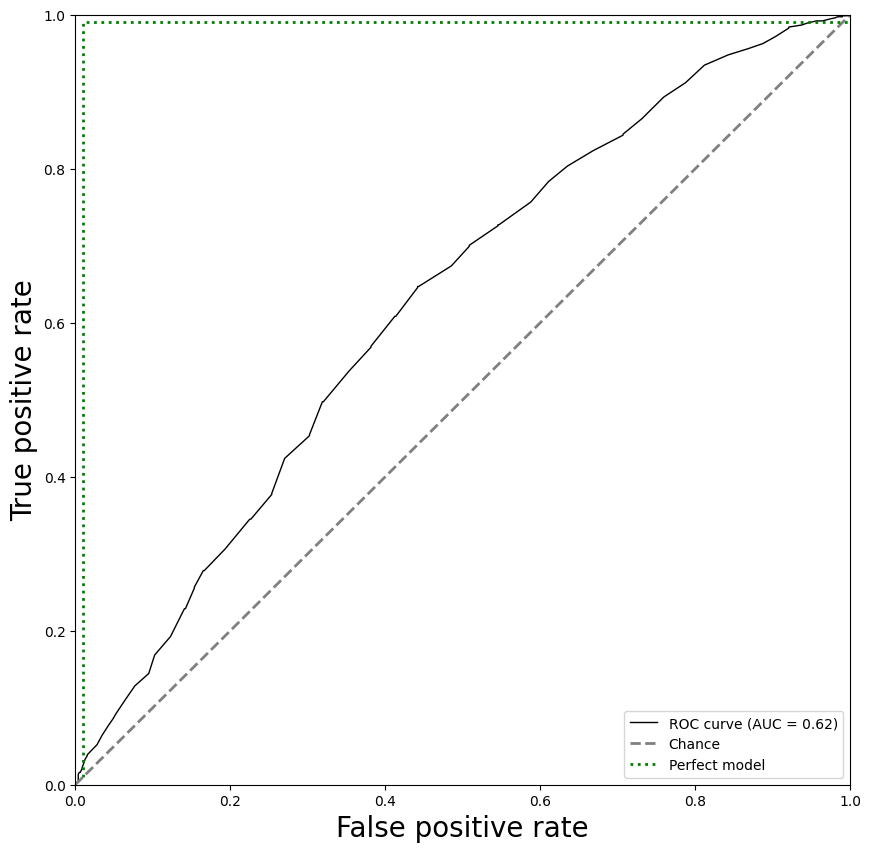

In [22]:
get_roc_plot(y_predicted_proba[:, 1], y_test, figsize=(10, 10))

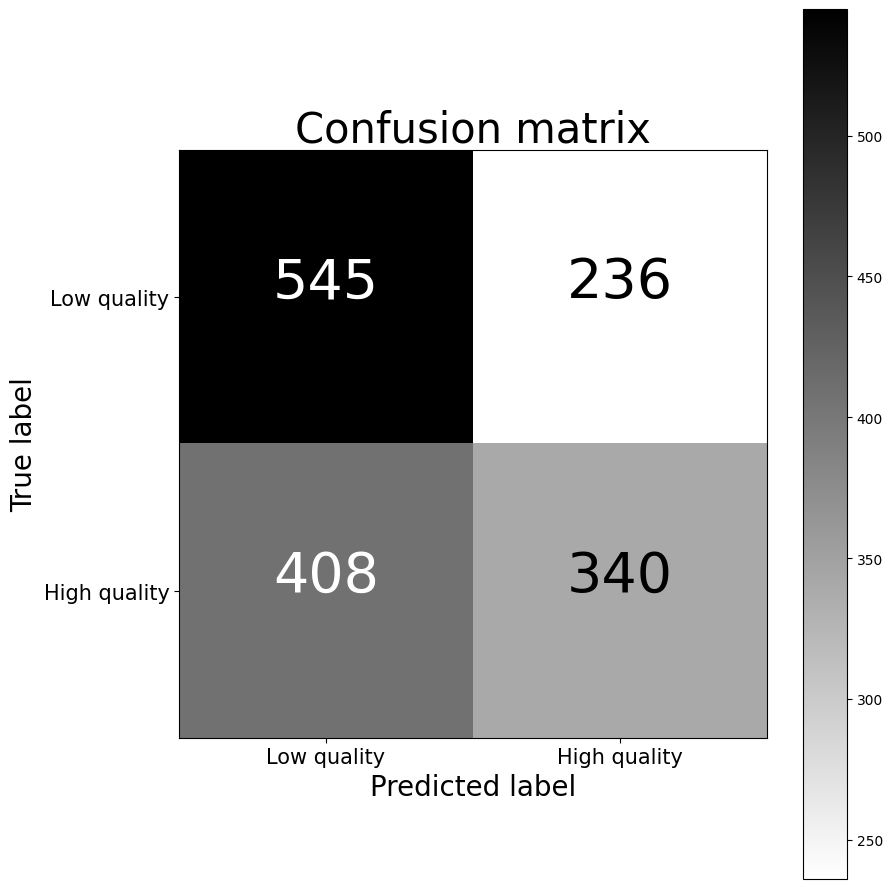

In [23]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9,9))

	Brier: 0.239


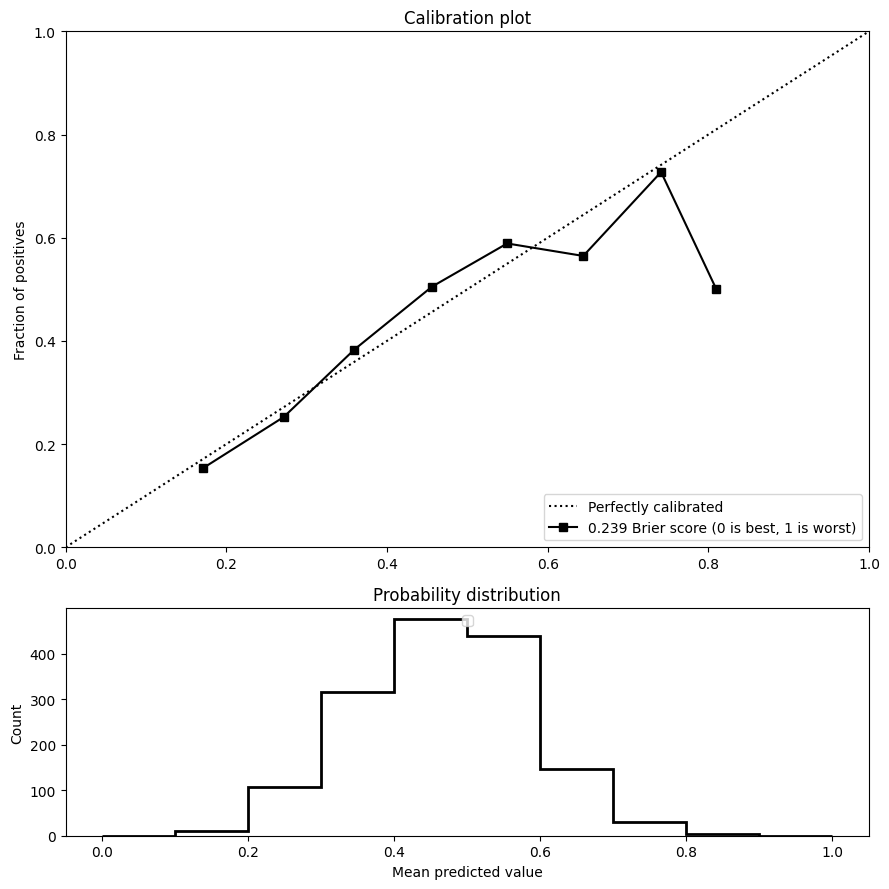

In [24]:
get_calibration_plot(y_predicted_proba[:, 1], y_test, figsize=(9,9))

## Running inference

In [27]:
pos_prob=get_question_score_from_input(["""
Whwn quoting a person's informal speech, how much liberty do you have to make changes to what they say?
"""])
print(f"{pos_prob} probability of the question receiving a high score according to our model")

AttributeError: 'list' object has no attribute 'lower'

In [28]:
text_array = ["""When quoting a person's informal speech, how much liberty do you have to make changes to what they say?"""]
pos_prob = get_question_score_from_input(text_array)


AttributeError: 'list' object has no attribute 'lower'